In [1]:
!pip install timm torchvision tqdm kaggle --quiet

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 112.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 77.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 55.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 6.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 11.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 6.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 5.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 54.0 MB/s eta 0:00:00


In [2]:
from google.colab import files
import os
files.upload()
os.makedirs('/root/.kaggle', exist_ok=True)
!mv kaggle.json /root/.kaggle/
!chmod 600 /root/.kaggle/kaggle.json

Saving kaggle.json to kaggle.json


In [3]:
!kaggle datasets download -d nickfratto/pacs-dataset
!unzip -q pacs-dataset.zip -d /content/pacs
!chmod -R 755 /content/pacs

Dataset URL: https://www.kaggle.com/datasets/nickfratto/pacs-dataset
License(s): unknown
100% 524M/526M [00:05<00:00, 83.3MB/s]
100% 526M/526M [00:05<00:00, 99.9MB/s]


In [4]:
!ls /content/pacs/pacs_data/pacs_data

art_painting  cartoon  photo  sketch


In [5]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import transforms, datasets
from torch.utils.data import DataLoader, ConcatDataset, Subset
import timm
from tqdm import tqdm
import numpy as np
import matplotlib.pyplot as plt


In [6]:
def load_pacs_splits(domain, train_ratio=0.8, subset_ratio=0.2):
    transform = transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406],
                             std=[0.229, 0.224, 0.225])
    ])

    full_dataset = datasets.ImageFolder(
        root=f'/content/pacs/pacs_data/pacs_data/{domain}',
        transform=transform
    )


    subset_size = int(len(full_dataset) * subset_ratio)
    indices = np.random.choice(len(full_dataset), subset_size, replace=False)
    subset = Subset(full_dataset, indices)


    train_size = int(train_ratio * len(subset))
    val_size = len(subset) - train_size
    train_subset, val_subset = torch.utils.data.random_split(subset, [train_size, val_size])

    return train_subset, val_subset



In [7]:
!ls /content/pacs/pacs_data/pacs_data/art_painting

dog  elephant  giraffe	guitar	horse  house  person


In [28]:
domains = ['art_painting', 'cartoon', 'photo', 'sketch']
train_subsets, val_subsets = [], []
for domain in domains:
    train, val = load_pacs_splits(domain, subset_ratio=1.0)
    train_subsets.append(train)
    val_subsets.append(val)

In [29]:
num_workers = 4 if torch.cuda.is_available() else 2
train_loader = DataLoader(
    ConcatDataset(train_subsets),
    batch_size=256,
    shuffle=True,
    num_workers=num_workers,
    pin_memory=True
)

val_loader = DataLoader(
    ConcatDataset(val_subsets),
    batch_size=256,
    num_workers=num_workers,
    pin_memory=True
)


In [30]:
class Adapter(nn.Module):
    def __init__(self, in_features, reduction_factor=4):
        super().__init__()
        self.adapter = nn.Sequential(
            nn.Linear(in_features, in_features // reduction_factor),
            nn.GELU(),
            nn.Linear(in_features // reduction_factor, in_features)
        )

    def forward(self, x):
        return x + self.adapter(x)

In [31]:
class ViTWithAdapters(nn.Module):
    def __init__(self, num_domains=4, num_classes=7):
        super().__init__()
        self.vit = timm.create_model('vit_base_patch16_224', pretrained=True)

        for param in self.vit.parameters():
            param.requires_grad = False


        self.num_domains = num_domains
        self.adapters = nn.ModuleList()

        for _ in range(num_domains):
            domain_adapters = nn.ModuleList()
            for block in self.vit.blocks:

                adapter_mhsa = Adapter(768)
                adapter_ffn = Adapter(768)
                domain_adapters.append(nn.ModuleDict({
                    'adapter_mhsa': adapter_mhsa,
                    'adapter_ffn': adapter_ffn
                }))
            self.adapters.append(domain_adapters)


        self.vit.head = nn.Linear(768, num_classes)

    def set_domain(self, domain_id):

        for block, adapters in zip(self.vit.blocks, self.adapters[domain_id]):
            block.adapter_mhsa = adapters['adapter_mhsa']
            block.adapter_ffn = adapters['adapter_ffn']

    def forward(self, x):
        return self.vit(x)

In [37]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = ViTWithAdapters().to(device)


In [38]:
criterion = nn.CrossEntropyLoss()

In [39]:
scaler = torch.amp.GradScaler()
optimizer = optim.Adam(model.parameters(), lr=2e-4)

In [40]:
epochs=20
train_losses, val_losses = [], []
train_accs, val_accs = [], []

In [41]:
for epoch in range(epochs):
    model.train()
    running_loss = 0.0
    correct_train = 0
    total_train = 0

    for batch_idx, (inputs, labels) in enumerate(tqdm(train_loader)):
        domain_id = batch_idx % 4
        model.set_domain(domain_id)

        inputs, labels = inputs.to(device), labels.to(device)

        with torch.amp.autocast(device_type='cuda', dtype=torch.float16):
            outputs = model(inputs)
            loss = criterion(outputs, labels)

        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()
        optimizer.zero_grad()

        running_loss += loss.item()
        _, predicted = torch.max(outputs.data, 1)
        total_train += labels.size(0)
        correct_train += (predicted == labels).sum().item()


    model.eval()
    val_loss = 0.0
    correct_val = 0
    total_val = 0

    with torch.no_grad(), torch.amp.autocast(device_type='cuda', dtype=torch.float16):
        for inputs, labels in val_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            val_loss += criterion(outputs, labels).item()

            _, predicted = torch.max(outputs.data, 1)
            total_val += labels.size(0)
            correct_val += (predicted == labels).sum().item()


    train_loss = running_loss/len(train_loader)
    val_loss = val_loss/len(val_loader)
    train_acc = 100 * correct_train/total_train
    val_acc = 100 * correct_val/total_val

    train_losses.append(train_loss)
    val_losses.append(val_loss)
    train_accs.append(train_acc)
    val_accs.append(val_acc)

    print(f'Epoch {epoch+1}: '
          f'Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f} | '
          f'Train Acc: {train_acc:.2f}%, Val Acc: {val_acc:.2f}%')

  0%|          | 0/32 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
100%|██████████| 32/32 [00:28<00:00,  1.12it/s]


Epoch 1: Train Loss: 1.7380, Val Loss: 1.3063 | Train Acc: 32.72%, Val Acc: 54.83%


100%|██████████| 32/32 [00:28<00:00,  1.14it/s]


Epoch 2: Train Loss: 1.0922, Val Loss: 0.9452 | Train Acc: 63.94%, Val Acc: 70.59%


100%|██████████| 32/32 [00:26<00:00,  1.21it/s]


Epoch 3: Train Loss: 0.8342, Val Loss: 0.7835 | Train Acc: 73.41%, Val Acc: 76.24%


100%|██████████| 32/32 [00:28<00:00,  1.10it/s]


Epoch 4: Train Loss: 0.7041, Val Loss: 0.6947 | Train Acc: 77.85%, Val Acc: 79.09%


100%|██████████| 32/32 [00:28<00:00,  1.14it/s]


Epoch 5: Train Loss: 0.6292, Val Loss: 0.6393 | Train Acc: 79.94%, Val Acc: 80.29%


100%|██████████| 32/32 [00:28<00:00,  1.14it/s]


Epoch 6: Train Loss: 0.5745, Val Loss: 0.5982 | Train Acc: 81.72%, Val Acc: 81.19%


100%|██████████| 32/32 [00:28<00:00,  1.12it/s]


Epoch 7: Train Loss: 0.5354, Val Loss: 0.5677 | Train Acc: 82.91%, Val Acc: 81.99%


100%|██████████| 32/32 [00:27<00:00,  1.15it/s]


Epoch 8: Train Loss: 0.5077, Val Loss: 0.5460 | Train Acc: 83.68%, Val Acc: 82.54%


100%|██████████| 32/32 [00:27<00:00,  1.15it/s]


Epoch 9: Train Loss: 0.4792, Val Loss: 0.5283 | Train Acc: 84.21%, Val Acc: 82.99%


100%|██████████| 32/32 [00:28<00:00,  1.12it/s]


Epoch 10: Train Loss: 0.4632, Val Loss: 0.5119 | Train Acc: 84.91%, Val Acc: 83.14%


100%|██████████| 32/32 [00:28<00:00,  1.14it/s]


Epoch 11: Train Loss: 0.4424, Val Loss: 0.4975 | Train Acc: 85.60%, Val Acc: 83.59%


100%|██████████| 32/32 [00:27<00:00,  1.15it/s]


Epoch 12: Train Loss: 0.4319, Val Loss: 0.4878 | Train Acc: 85.97%, Val Acc: 84.24%


100%|██████████| 32/32 [00:28<00:00,  1.14it/s]


Epoch 13: Train Loss: 0.4219, Val Loss: 0.4766 | Train Acc: 86.19%, Val Acc: 84.14%


100%|██████████| 32/32 [00:28<00:00,  1.14it/s]


Epoch 14: Train Loss: 0.4076, Val Loss: 0.4704 | Train Acc: 86.70%, Val Acc: 84.44%


100%|██████████| 32/32 [00:28<00:00,  1.14it/s]


Epoch 15: Train Loss: 0.3969, Val Loss: 0.4608 | Train Acc: 87.05%, Val Acc: 84.54%


100%|██████████| 32/32 [00:27<00:00,  1.18it/s]


Epoch 16: Train Loss: 0.3894, Val Loss: 0.4557 | Train Acc: 87.36%, Val Acc: 85.09%


100%|██████████| 32/32 [00:28<00:00,  1.13it/s]


Epoch 17: Train Loss: 0.3784, Val Loss: 0.4509 | Train Acc: 87.54%, Val Acc: 84.99%


100%|██████████| 32/32 [00:28<00:00,  1.13it/s]


Epoch 18: Train Loss: 0.3664, Val Loss: 0.4435 | Train Acc: 87.74%, Val Acc: 84.79%


100%|██████████| 32/32 [00:28<00:00,  1.12it/s]


Epoch 19: Train Loss: 0.3653, Val Loss: 0.4389 | Train Acc: 87.85%, Val Acc: 84.89%


100%|██████████| 32/32 [00:27<00:00,  1.15it/s]


Epoch 20: Train Loss: 0.3562, Val Loss: 0.4335 | Train Acc: 88.10%, Val Acc: 85.49%


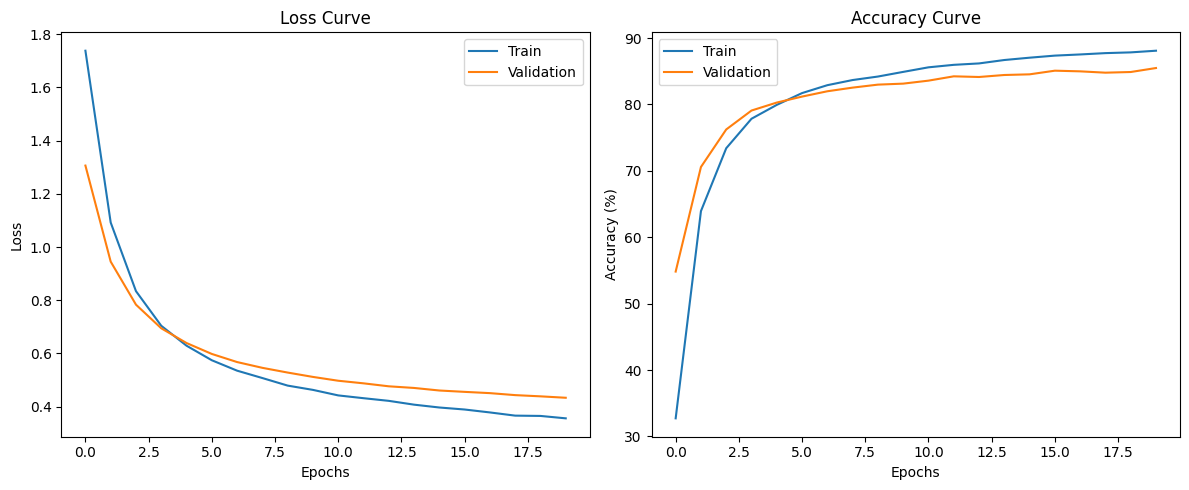

In [42]:
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Train')
plt.plot(val_losses, label='Validation')
plt.title('Loss Curve')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(train_accs, label='Train')
plt.plot(val_accs, label='Validation')
plt.title('Accuracy Curve')
plt.xlabel('Epochs')
plt.ylabel('Accuracy (%)')
plt.legend()

plt.tight_layout()
plt.savefig('training_metrics.png')
plt.show()


torch.save(model.state_dict(), 'vit_adapters.pth')

In [48]:
os.makedirs('models', exist_ok=True)


torch.save({
    'epoch': epoch,
    'model_state_dict': model.state_dict(),
    'optimizer_state_dict': optimizer.state_dict(),
    'loss': criterion,
    'val_acc': val_acc
}, 'models/vit_adapter.pth')

print("Model saved successfully at models/vit_adapter.pth")

Model saved successfully at models/vit_adapter.pth
